In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Helper_Functions import Generate_Features, Quality_Evaluation
from skimage.io import imread
from skimage.transform import rescale
from sklearn.ensemble import RandomForestClassifier
from skimage.segmentation import random_walker
from multiprocessing import cpu_count
from skimage.morphology import opening, disk
import os
from sklearn.externals import joblib
from scipy.ndimage.morphology import binary_fill_holes


In [2]:
def RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True):
    nx,ny=Image.shape[0:2]
    Test_Features=np.reshape(Generate_Features(Image),[54,nx*ny]).T
    Prediction = RF.predict_proba(Test_Features)
    Prediction = Prediction.reshape([nx,ny,2])
    if PP==False:
        return Prediction[:,:,1]>0.5
    else:
        Non_Road_Seeds = Prediction[:,:,0]>thres1
        Sky=np.zeros(Prediction[:,:,0].shape, dtype=bool)
        Sky[0:sky_height,:]=True
        Non_Road_Seeds=(Non_Road_Seeds|Sky) 
        Non_Road_Seeds[mask_Ego_Vehicle]=False
        selem = disk(3)
        Non_Road_Seeds=opening(Non_Road_Seeds,selem)

        Road_Seeds=Prediction[:,:,1]>thres2
        Road_Seeds[0:110,:]=False
        Road_Seeds=Road_Seeds|mask_Ego_Vehicle
        selem = disk(7)
        Road_Seeds=opening(Road_Seeds,selem)
        labels=np.zeros(Prediction[:,:,0].shape, dtype=int)

        labels[Non_Road_Seeds]=1
        labels[Road_Seeds]=2

        Segmentation=random_walker(Image, labels, beta=250, multichannel=True)
        Result=np.zeros([nx,ny], dtype=bool)
        Result[Segmentation==2]=True
        Result=binary_fill_holes(Result)
        Result[mask_Ego_Vehicle]=False
        Result[mask_out_of_roi]=False
        return Result

In [3]:
def Get_Image_and_Ground_Truth(GT_path,Im_path):
    GT=[]
    Im=[]
    for file in os.listdir(GT_path):
        if file.endswith("_gtFine_labelIds.png"):
            GT.append(file)


    Im=os.listdir(Im_path)

    GT=sorted(GT)
    Im=sorted(Im)
    return GT,Im

In [4]:
RF = joblib.load('RF_aachen_mxd20est256.pkl')
print("Random Forest Model Loaded")

Random Forest Model Loaded


In [5]:
#print(RF.feature_importances_)

In [6]:
#"aachen",
towns=["bochum","bremen","cologne","darmstadt","dusseldorf",
       "erfurt","hamburg","hanover","jena","krefeld","monchengladbach",
       "strasbourg","stuttgart","tubingen","ulm","weimar","zurich"]
Im_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Images/train/"
GT_path="/home/thanos/Desktop/Project_ADAS_2017/CITYSCAPE/Ground_Truth/train/"

scale_factor=0.25

P=[]
C=[]
Q=[]

P2=[]
C2=[]
Q2=[]
for town in towns:
    Im_path_town=Im_path+town
    GT_path_town=GT_path+town
    
    GT=[]
    Im=[]
    GT,Im=Get_Image_and_Ground_Truth(GT_path_town,Im_path_town)
    #P1=[]
    #P2=[]
    #C1=[]
    #C2=[]
    #Q1=[]
    #Q2=[]
    steps=len(GT)
    for i in range(0,steps):   
        Image=imread(Im_path+town+"/"+Im[i])
        labels=imread(GT_path+town+"/"+GT[i])

        Image=rescale(Image,scale_factor,mode='reflect')

        labels=rescale(labels,scale_factor,mode='reflect', preserve_range=True)

        nx,ny=Image.shape[0:2]
        mask_out_of_roi = labels==3
        mask_Ego_Vehicle = labels==1
        Ground_Truth=labels==7


        Result1=RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=True)
        Result2=RF_Post_Processed(Image,mask_Ego_Vehicle,mask_out_of_roi,thres1=0.9,thres2=0.5,sky_height=50,PP=False)
# 
#         Im1=Image.copy()
#         Im2=Image.copy()
#         Im3=Image.copy()

#         Im1[:,:,0][Result1]=1
#         Im2[:,:,0][Ground_Truth]=1
#         Im3[:,:,0][Result1]=1
#         Im3[:,:,1][Ground_Truth]=1

#         plt.figure(figsize=(20,10))
#         plt.suptitle('RF vs Ground Truth Image={},Town={}'.format(Im[i],town),y=0.7, fontsize=20)
#         plt.subplot(131).axis("off")
#         plt.imshow(Im1)
#         plt.title("RF result")
#         plt.subplot(132).axis("off")
#         plt.imshow(Im2)
#         plt.title("Ground Trouth")
#         plt.subplot(133).axis("off")
#         plt.imshow(Im3)
#         plt.title("TP,FP,FN")
#         plt.show()
        if np.sum(np.array(Ground_Truth))>10:
            Precision1, Completeness1, Quality1 = Quality_Evaluation(Result1,Ground_Truth)
            Precision2, Completeness2, Quality2 = Quality_Evaluation(Result2,Ground_Truth)

            if (Precision1<0.5 or Completeness1<0.5 or Quality1<0.5):
                print("Bad Quality, {} ".format(Im[i]))
                print(np.sum(np.array(Ground_Truth)))

            #P1.append(Precision1)
            #C1.append(Completeness1)
            #Q1.append(Quality1)
            
            P.append(Precision1)
            C.append(Completeness1)
            Q.append(Quality1)

            P2.append(Precision2)
            C2.append(Completeness2)
            Q2.append(Quality2)
        else:
            print("Ground Truth Image {} doesnt contain class road".format(Im[i]))

    #P1=np.array(P1)
    #C1=np.array(C1)
    #Q1=np.array(Q1)
    
    #mean_P1=np.mean(P1)
    #mean_C1=np.mean(C1)
    #mean_Q1=np.mean(Q1)

    #var_P1=np.var(P1)
    #var_C1=np.var(C1)
    #var_Q1=np.var(Q1)
    
    #max_C1=np.max(C1)
    #min_C1=np.min(C1)
    
    #max_P1=np.max(P1)
    #min_P1=np.min(P1)
    
    #max_Q1=np.max(Q1)
    #min_Q1=np.min(Q1)
    
    #P2=np.array(P2)
    #C2=np.array(C2)
    #Q2=np.array(Q2)
    #mean_P2=np.mean(P2)
    #mean_C2=np.mean(C2)
    #mean_Q2=np.mean(Q2)

    #var_P2=np.var(P2)
    #var_C2=np.var(C2)
    #var_Q2=np.var(Q2)
    
    #max_C2=np.max(C2)
    #min_C2=np.min(C2)
    
    #max_P2=np.max(P2)
    #min_P2=np.min(P2)
    
    #max_Q2=np.max(Q2)
    #min_Q2=np.min(Q2)


    #plt.figure()
    #plt.plot(P1)
    #plt.plot(P2)
    #plt.title("Precision")
    #plt.show()

    #plt.figure()
    #plt.plot(C1)
    #plt.plot(C2)
    #plt.title("Recall")
    #plt.show()

    #plt.figure()
    #plt.plot(Q1)
    #plt.plot(Q2)
    #plt.title("Quality")
    #plt.show()
    
    #print("City = {}".format(town))
    #print("Results with Smoothing")
    #print("Precision")
    #print("Mean, Var, max, min")
    #print(mean_P1,var_P1,max_P1,min_P1)
    #print("Recall")
    #print(mean_C1,var_C1,max_C1,min_C1)
    #print("Quality")
    #print(mean_Q1,var_Q1,max_Q1,min_Q1)
    #print("Results without Smoothing")
    #print("Precision")
    #print(mean_P2,var_P2,max_P2,min_P2)
    #print("Recall")
    #print(mean_C2,var_C2,max_C2,min_C2)
    #print("Quality")
    #print(mean_Q2,var_Q2,max_Q2,min_Q2)

Bad Quality, bochum_000000_015645_leftImg8bit.png 
45945
Bad Quality, bochum_000000_015880_leftImg8bit.png 
42625
Bad Quality, bochum_000000_016125_leftImg8bit.png 
35318
Bad Quality, bochum_000000_016260_leftImg8bit.png 
21927
Bad Quality, bochum_000000_018195_leftImg8bit.png 
37178
Bad Quality, bochum_000000_027699_leftImg8bit.png 
51784
Bad Quality, bochum_000000_028764_leftImg8bit.png 
42537
Bad Quality, bremen_000001_000019_leftImg8bit.png 
39180
Bad Quality, bremen_000004_000019_leftImg8bit.png 
16878
Bad Quality, bremen_000010_000019_leftImg8bit.png 
16455
Bad Quality, bremen_000028_000019_leftImg8bit.png 
30785
Bad Quality, bremen_000040_000019_leftImg8bit.png 
25249
Bad Quality, bremen_000047_000019_leftImg8bit.png 
39402
Bad Quality, bremen_000053_000019_leftImg8bit.png 
30259
Bad Quality, bremen_000073_000019_leftImg8bit.png 
3621
Bad Quality, bremen_000082_000019_leftImg8bit.png 
25277
Bad Quality, bremen_000084_000019_leftImg8bit.png 
22090
Bad Quality, bremen_000089_00001

Bad Quality, hamburg_000000_085982_leftImg8bit.png 
40818
Bad Quality, hamburg_000000_086499_leftImg8bit.png 
54897
Bad Quality, hamburg_000000_088054_leftImg8bit.png 
52112
Bad Quality, hamburg_000000_088197_leftImg8bit.png 
37638
Bad Quality, hamburg_000000_088783_leftImg8bit.png 
38369
Ground Truth Image hamburg_000000_089491_leftImg8bit.png doesnt contain class road
Bad Quality, hamburg_000000_090398_leftImg8bit.png 
39461
Bad Quality, hamburg_000000_091038_leftImg8bit.png 
41364
Bad Quality, hamburg_000000_092850_leftImg8bit.png 
43886
Bad Quality, hamburg_000000_093572_leftImg8bit.png 
52516
Bad Quality, hamburg_000000_093787_leftImg8bit.png 
28687
Bad Quality, hamburg_000000_094717_leftImg8bit.png 
41056
Bad Quality, hamburg_000000_098061_leftImg8bit.png 
38806
Bad Quality, hamburg_000000_104857_leftImg8bit.png 
571
Ground Truth Image hamburg_000000_105123_leftImg8bit.png doesnt contain class road
Bad Quality, hanover_000000_005732_leftImg8bit.png 
30142
Bad Quality, hanover_000

Bad Quality, strasbourg_000001_053222_leftImg8bit.png 
34027
Bad Quality, strasbourg_000001_053579_leftImg8bit.png 
31217
Bad Quality, strasbourg_000001_060173_leftImg8bit.png 
37349
Bad Quality, stuttgart_000002_000019_leftImg8bit.png 
50757
Bad Quality, stuttgart_000004_000019_leftImg8bit.png 
44297
Bad Quality, stuttgart_000007_000019_leftImg8bit.png 
61033
Bad Quality, stuttgart_000011_000019_leftImg8bit.png 
41232
Bad Quality, stuttgart_000020_000019_leftImg8bit.png 
42806
Bad Quality, stuttgart_000022_000019_leftImg8bit.png 
37180
Bad Quality, stuttgart_000027_000019_leftImg8bit.png 
46648
Bad Quality, stuttgart_000030_000019_leftImg8bit.png 
34908
Bad Quality, stuttgart_000036_000019_leftImg8bit.png 
26699
Bad Quality, stuttgart_000039_000019_leftImg8bit.png 
50841
Bad Quality, stuttgart_000045_000019_leftImg8bit.png 
51682
Bad Quality, stuttgart_000046_000019_leftImg8bit.png 
45620
Bad Quality, stuttgart_000047_000019_leftImg8bit.png 
40615
Bad Quality, stuttgart_000049_000019_

Bad Quality, zurich_000044_000019_leftImg8bit.png 
26191
Bad Quality, zurich_000064_000019_leftImg8bit.png 
37614
Bad Quality, zurich_000076_000019_leftImg8bit.png 
48812
Bad Quality, zurich_000078_000019_leftImg8bit.png 
55133
Bad Quality, zurich_000091_000019_leftImg8bit.png 
32874
Bad Quality, zurich_000098_000019_leftImg8bit.png 
48788
Bad Quality, zurich_000109_000019_leftImg8bit.png 
50241
Bad Quality, zurich_000115_000019_leftImg8bit.png 
39241
Bad Quality, zurich_000117_000019_leftImg8bit.png 
36624


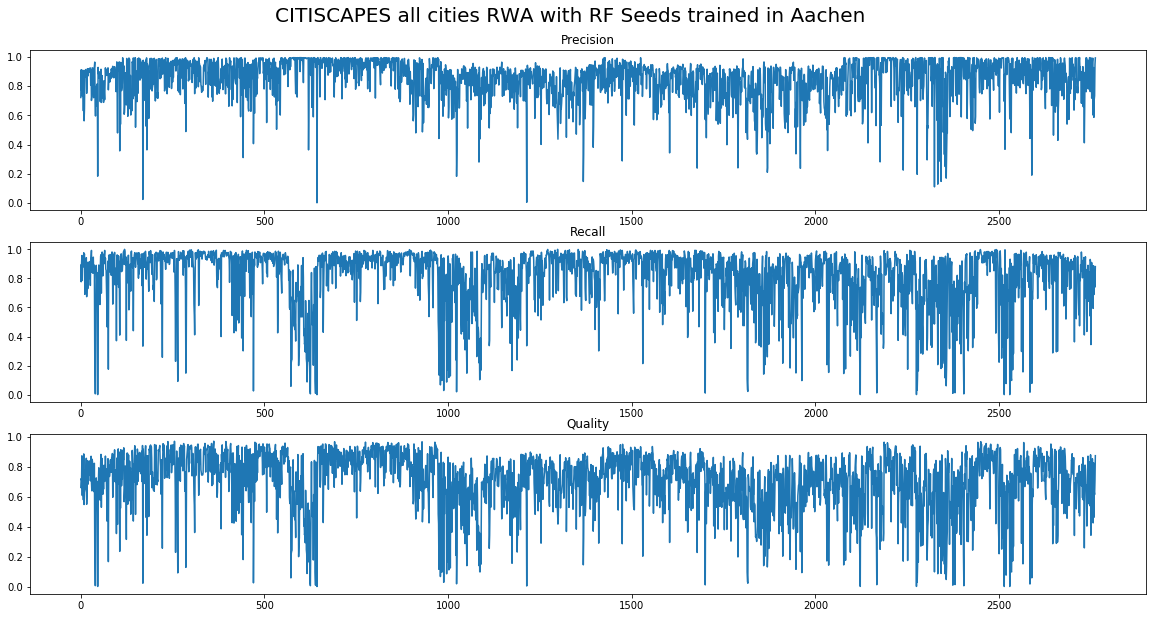

Results for all Cities with RF Seeds trained in Aachen
Precision
Mean, Var, max, min
0.8521375912210553 0.01998002388303168 0.9971003647928164 0.0
Recall
0.8109864010337677 0.041707431888113364 1.0 0.0
Quality
0.7090034213536822 0.03885187061211015 0.9737754621965882 0.0


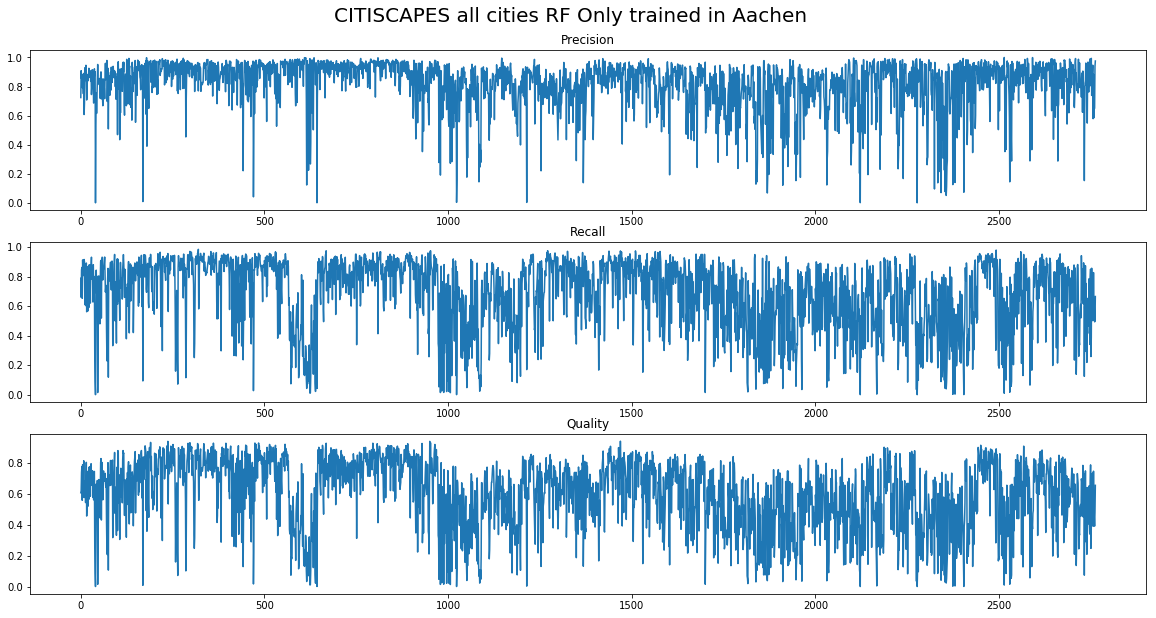

Results for all Cities RF Only trained in Aachen
Precision
Mean, Var, max, min
0.8178914388153404 0.02870115190481615 1.0 0.0
Recall
0.6789934894206071 0.056201892746885675 0.9854218165684224 0.0
Quality
0.5966687999348281 0.04929057826588737 0.9401696581837575 0.0


In [7]:
P=np.array(P)
C=np.array(C)
Q=np.array(Q)
    
mean_P=np.mean(P)
mean_C=np.mean(C)
mean_Q=np.mean(Q)

var_P=np.var(P)
var_C=np.var(C)
var_Q=np.var(Q)
    
max_C=np.max(C)
min_C=np.min(C)
    
max_P=np.max(P)
min_P=np.min(P)

max_Q=np.max(Q)
min_Q=np.min(Q)

plt.figure(figsize=(20,10))
plt.suptitle('CITISCAPES all cities RWA with RF Seeds trained in Aachen',y=0.94, fontsize=20)     
plt.subplot(311)
plt.plot(P)
plt.title("Precision")
plt.subplot(312)
plt.plot(C)
plt.title("Recall")
plt.subplot(313)
plt.plot(Q)
plt.title("Quality")
plt.show()

print("Results for all Cities with RF Seeds trained in Aachen")
print("Precision")
print("Mean, Var, max, min")
print(mean_P,var_P,max_P,min_P)
print("Recall")
print(mean_C,var_C,max_C,min_C)
print("Quality")
print(mean_Q,var_Q,max_Q,min_Q)


P2=np.array(P2)
C2=np.array(C2)
Q2=np.array(Q2)
    
mean_P2=np.mean(P2)
mean_C2=np.mean(C2)
mean_Q2=np.mean(Q2)

var_P2=np.var(P2)
var_C2=np.var(C2)
var_Q2=np.var(Q2)
    
max_C2=np.max(C2)
min_C2=np.min(C2)
    
max_P2=np.max(P2)
min_P2=np.min(P2)

max_Q2=np.max(Q2)
min_Q2=np.min(Q2)


plt.figure(figsize=(20,10))
plt.suptitle('CITISCAPES all cities RF Only trained in Aachen',y=0.94, fontsize=20)     
plt.subplot(311)
plt.plot(P2)
plt.title("Precision")
plt.subplot(312)
plt.plot(C2)
plt.title("Recall")
plt.subplot(313)
plt.plot(Q2)
plt.title("Quality")
plt.show()

print("Results for all Cities RF Only trained in Aachen")
print("Precision")
print("Mean, Var, max, min")
print(mean_P2,var_P2,max_P2,min_P2)
print("Recall")
print(mean_C2,var_C2,max_C2,min_C2)
print("Quality")
print(mean_Q2,var_Q2,max_Q2,min_Q2)